# NNFL ASSIGNMENT
### Temporal Segment Networks


Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Install Keras Video Generator

In [2]:
pip install keras-video-generators

  Created wheel for keras-video-generators: filename=keras_video_generators-1.0.14-cp37-none-any.whl size=12884 sha256=5bd681fc2306555e89f92bd92e0444a85c6841ce55c873a789bc6f884321fd23
  Stored in directory: /root/.cache/pip/wheels/20/b7/76/8674d46fc4777c09e5aa7b065d4e356d90f12ec409a6144bbb
Successfully built keras-video-generators


Unzip Video Dataset 

In [3]:
!mkdir rars && mkdir videos
!unrar x /content/gdrive/MyDrive/TSN_DATASET/hmdb51_org.rar rars/
!for a in $(ls rars); do unrar x "rars/${a}" videos/; done;

Streaming output truncated to the last 5000 lines.
Extracting  videos/hit/Drum_Beats_-_Drum_Beats-_Slow_Blues_hit_u_cm_np1_le_bad_0.avi      23%  OK 
Extracting  videos/hit/Drum_Beats_-_Drum_Beats-_Slow_Blues_hit_u_cm_np1_le_bad_1.avi      24%  OK 
Extracting  videos/hit/Drum_Beats_-_Drum_Beats-_Slow_Blues_hit_u_cm_np1_le_bad_2.avi      24%  OK 
Extracting  videos/hit/Einde_van_Opel_Kadett_hit_f_cm_np1_le_bad_2.avi      25%  OK 
Extracting  videos/hit/Einde_van_Opel_Kadett_hit_f_cm_np1_le_bad_3.avi      25% 26%  OK 
Extracting  videos/hit/Einde_van_Opel_Kadett_hit_f_cm_np1_ri_bad_10.avi      26%  OK 
Extracting  videos/hit/Einde_van_Opel_Kadett_hit_f_cm_np1_ri_bad_4.avi      26% 27%  OK 
Extracting  videos/hit/Einde_van_Opel_Kadett_hit_f_cm_np1_ri_bad_5.avi      27% 28%  OK 
Extracting  videos/hit/Einde_van_Opel_Kadett_hit_f_cm_np1_ri_bad_9.avi      28%  OK 
Extracting  videos/hit/Einde_van_Ope

Importing libraries and Defining Classes

In [4]:
import os
import glob
import keras
from keras_video import VideoFrameGenerator


# use sub directories names as classes
classes = ['clap','cartwheel','smile','situp','sit','shoot_gun']
classes.sort()
classes

['cartwheel', 'clap', 'shoot_gun', 'sit', 'situp', 'smile']

In [5]:
import os
import glob
import numpy as np
import cv2 as cv
from math import floor
import logging
import re
log = logging.getLogger()

from keras.utils import Sequence
from keras.preprocessing.image import \
    ImageDataGenerator, img_to_array


class MyVideoFrameGenerator(Sequence):
    """
    Create a generator that return batches of frames from video
    - rescale: float fraction to rescale pixel data (commonly 1/255.)
    - nb_frames: int, number of frames to return for each sequence
    - classes: list of str, classes to infer
    - batch_size: int, batch size for each loop
    - use_frame_cache: bool, use frame cache (may take a lot of memory for \
        large dataset)
    - shape: tuple, target size of the frames
    - shuffle: bool, randomize files
    - transformation: ImageDataGenerator with transformations
    - split: float, factor to split files and validation
    - nb_channel: int, 1 or 3, to get grayscaled or RGB images
    - glob_pattern: string, directory path with '{classname}' inside that \
        will be replaced by one of the class list
    - use_header: bool, default to True to use video header to read the \
        frame count if possible
    You may use the "classes" property to retrieve the class list afterward.
    The generator has that properties initialized:
    - classes_count: number of classes that the generator manages
    - files_count: number of video that the generator can provides
    - classes: the given class list
    - files: the full file list that the generator will use, this \
        is usefull if you want to remove some files that should not be \
        used by the generator.
    """

    def __init__(
            self,
            rescale=1/255.,
            nb_frames: int = 5,
            classes: list = None,
            batch_size: int = 16,
            use_frame_cache: bool = False,
            target_shape: tuple = (224, 224),
            shuffle: bool = True,
            transformation: ImageDataGenerator = None,
            split_test: float = None,
            split_val: float = None,
            nb_channel: int = 3,
            glob_pattern: str = './videos/{classname}/*.avi',
            use_headers: bool = True,
            *args,
            **kwargs):

        # deprecation
        if 'split' in kwargs:
            log.warn("Warning, `split` argument is replaced by `split_val`, "
                     "please condider to change your source code."
                     "The `split` argument will be removed "
                     "in future releases.")
            split_val = float(kwargs.get('split'))

        self.glob_pattern = glob_pattern

        # should be only RGB or Grayscale
        assert nb_channel in (1, 3)

        if classes is None:
            classes = self._discover_classes()

        # we should have classes
        if len(classes) == 0:
            log.warn("You didn't provide classes list or "
                     "we were not able to discover them from "
                     "your pattern.\n"
                     "Please check if the path is OK, and if the glob "
                     "pattern is correct.\n"
                     "See https://docs.python.org/3/library/glob.html")

        # shape size should be 2
        assert len(target_shape) == 2

        # split factor should be a propoer value
        if split_val is not None:
            assert 0.0 < split_val < 1.0

        if split_test is not None:
            assert 0.0 < split_test < 1.0

        self.use_video_header = use_headers

        # then we don't need None anymore
        split_val = split_val if split_val is not None else 0.0
        split_test = split_test if split_test is not None else 0.0

        # be sure that classes are well ordered
        classes.sort()

        self.rescale = rescale
        self.classes = classes
        self.batch_size = batch_size
        self.nbframe = nb_frames
        self.shuffle = shuffle
        self.target_shape = target_shape
        self.nb_channel = nb_channel
        self.transformation = transformation
        self.use_frame_cache = use_frame_cache

        self._random_trans = []
        self.__frame_cache = {}
        self.files = []
        self.validation = []
        self.test = []

        _validation_data = kwargs.get('_validation_data', None)
        _test_data = kwargs.get('_test_data', None)

        if _validation_data is not None:
            # we only need to set files here
            self.files = _validation_data

        elif _test_data is not None:
            # we only need to set files here
            self.files = _test_data

        else:
            if split_val > 0 or split_test > 0:
                for cls in classes:
                    files = glob.glob(glob_pattern.format(classname=cls))
                    nbval = 0
                    nbtest = 0
                    info = []

                    # generate validation and test indexes
                    indexes = np.arange(len(files))

                    if shuffle:
                        np.random.shuffle(indexes)

                    if 0.0 < split_val < 1.0:
                        nbval = int(split_val * len(files))
                        nbtrain = len(files) - nbval

                        # get some sample for validation_data
                        val = np.random.permutation(indexes)[:nbval]

                        # remove validation from train
                        indexes = np.array(
                            [i for i in indexes if i not in val])
                        self.validation += [files[i] for i in val]
                        info.append("validation count: %d" % nbval)

                    if 0.0 < split_test < 1.0:
                        nbtest = int(split_test * nbtrain)
                        nbtrain = len(files) - nbval - nbtest

                        # get some sample for test_data
                        val_test = np.random.permutation(indexes)[:nbtest]

                        # remove test from train
                        indexes = np.array(
                            [i for i in indexes if i not in val_test])
                        self.test += [files[i] for i in val_test]
                        info.append("test count: %d" % nbtest)

                    # and now, make the file list
                    self.files += [files[i] for i in indexes]
                    print("class %s, %s, train count: %d" %
                          (cls, ", ".join(info), nbtrain))

            else:
                for cls in classes:
                    self.files += glob.glob(glob_pattern.format(classname=cls))

        # build indexes
        self.files_count = len(self.files)
        self.indexes = np.arange(self.files_count)
        self.classes_count = len(classes)

        # to initialize transformations and shuffle indices
        if 'no_epoch_at_init' not in kwargs:
            self.on_epoch_end()

        kind = "train"
        if _validation_data is not None:
            kind = "validation"
        elif _test_data is not None:
            kind = "test"

        self._current = 0
        self._framecounters = {}
        print("Total data: %d classes for %d files for %s" % (
            self.classes_count,
            self.files_count,
            kind))

    def count_frames(self, cap, name, force_no_headers=False):
        """ Count number of frame for video
        if it's not possible with headers """
        if not force_no_headers and name in self._framecounters:
            return self._framecounters[name]

        total = cap.get(cv.CAP_PROP_FRAME_COUNT)

        if force_no_headers or total < 0:
            # headers not ok
            total = 0
            # TODO: we're unable to use CAP_PROP_POS_FRAME here
            # so we open a new capture to not change the
            # pointer position of "cap"
            c = cv.VideoCapture(name)
            while True:
                grabbed, frame = c.read()
                if not grabbed:
                    # rewind and stop
                    break
                total += 1

        # keep the result
        self._framecounters[name] = total

        return total

    def _discover_classes(self):
        pattern = os.path.realpath(self.glob_pattern)
        pattern = re.escape(pattern)
        pattern = pattern.replace('\\{classname\\}', '(.*?)')
        pattern = pattern.replace('\\*', '.*')

        files = glob.glob(self.glob_pattern.replace('{classname}', '*'))
        classes = set()
        for f in files:
            f = os.path.realpath(f)
            cl = re.findall(pattern, f)[0]
            classes.add(cl)

        return list(classes)

    def next(self):
        """ Return next element"""
        elem = self[self._current]
        self._current += 1
        if self._current == len(self):
            self._current = 0
            self.on_epoch_end()

        return elem

    def get_validation_generator(self):
        """ Return the validation generator if you've provided split factor """
        return self.__class__(
            nb_frames=self.nbframe,
            nb_channel=self.nb_channel,
            target_shape=self.target_shape,
            classes=self.classes,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
            rescale=self.rescale,
            glob_pattern=self.glob_pattern,
            use_headers=self.use_video_header,
            _validation_data=self.validation)

    def get_test_generator(self):
        """ Return the validation generator if you've provided split factor """
        return self.__class__(
            nb_frames=self.nbframe,
            nb_channel=self.nb_channel,
            target_shape=self.target_shape,
            classes=self.classes,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
            rescale=self.rescale,
            glob_pattern=self.glob_pattern,
            use_headers=self.use_video_header,
            _test_data=self.test)

    def on_epoch_end(self):
        """ Called by Keras after each epoch """

        if self.transformation is not None:
            self._random_trans = []
            for _ in range(self.files_count):
                self._random_trans.append(
                    self.transformation.get_random_transform(self.target_shape)
                )

        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        return int(np.floor(self.files_count / self.batch_size))

    def __getitem__(self, index):
        classes = self.classes
        shape = self.target_shape
        nbframe = self.nbframe

        labels = []
        images = []

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        transformation = None

        for i in indexes:
            # prepare a transformation if provided
            if self.transformation is not None:
                transformation = self._random_trans[i]

            video = self.files[i]
            classname = self._get_classname(video)

            # create a label array and set 1 to the right column
            label = np.zeros(len(classes))
            col = classes.index(classname)
            label[col] = 1.

            if video not in self.__frame_cache:
                frames = self._get_frames(
                    video,
                    nbframe,
                    shape,
                    force_no_headers=not self.use_video_header)
                if frames is None:
                    # avoid failure, nevermind that video...
                    continue

                # add to cache
                if self.use_frame_cache:
                    self.__frame_cache[video] = frames

            else:
                frames = self.__frame_cache[video]

            # apply transformation
            if transformation is not None:
                frames = [self.transformation.apply_transform(
                    frame, transformation) for frame in frames]

            # add the sequence in batch
            images.append(frames)
            labels.append(label)

        return np.array(images), np.array(labels)

    def _get_classname(self, video: str) -> str:
        """ Find classname from video filename following the pattern """

        # work with real path
        video = os.path.realpath(video)
        pattern = os.path.realpath(self.glob_pattern)

        # remove special regexp chars
        pattern = re.escape(pattern)

        # get back "*" to make it ".*" in regexp
        pattern = pattern.replace('\\*', '.*')

        # use {classname} as a capture
        pattern = pattern.replace('\\{classname\\}', '(.*?)')

        # and find all occurence
        classname = re.findall(pattern, video)[0]
        return classname

    def _get_frames(self, video, nbframe, shape, force_no_headers=False):
        cap = cv.VideoCapture(video)
        total_frames = self.count_frames(cap, video, force_no_headers)
        orig_total = total_frames
        if total_frames % 2 != 0:
            total_frames += 1
        frame_step = floor(total_frames/(nbframe-1))
        # TODO: fix that, a tiny video can have a frame_step that is
        # under 1
        frame_step = max(1, frame_step)
        frames = []
        frame_i = 0

        while True:
            grabbed, frame = cap.read()
            if not grabbed:
                break

            frame_i += 1
            if frame_i == 1 or frame_i % frame_step == 0 or frame_i == orig_total:
                # resize
                frame = cv.resize(frame, shape)

                # use RGB or Grayscale ?
                if self.nb_channel == 3:
                    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
                else:
                    frame = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)

                # to np
                frame = img_to_array(frame) * self.rescale

                # keep frame
                frames.append(frame)

            if len(frames) == nbframe:
                break

        cap.release()

        if not force_no_headers and len(frames) != nbframe:
            # There is a problem here
            # That means that frame count in header is wrong or broken,
            # so we need to force the full read of video to get the right
            # frame counter
            return self._get_frames(
                    video,
                    nbframe,
                    shape,
                    force_no_headers=True)

        if force_no_headers and len(frames) != nbframe:
            # and if we really couldn't find the real frame counter
            # so we return None. Sorry, nothing can be done...
            log.error("Frame count is not OK for video %s, "
                      "%d total, %d extracted" % (
                        video, total_frames, len(frames)))
            return None

        return np.array(frames)

In [6]:
# some global params
SIZE = (112, 112)
CHANNELS = 3
NBFRAME = 5
BS = 8
# pattern to get videos and classes
glob_pattern='/content/videos/{classname}/*.avi'
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)
# Create video frame generator
train = MyVideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.15,
    split_test = .15,
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

class cartwheel, validation count: 16, test count: 13, train count: 78
class clap, validation count: 19, test count: 16, train count: 95
class shoot_gun, validation count: 15, test count: 13, train count: 75
class sit, validation count: 21, test count: 18, train count: 103
class situp, validation count: 15, test count: 13, train count: 77
class smile, validation count: 15, test count: 13, train count: 74
Total data: 6 classes for 502 files for train


In [7]:
valid = train.get_validation_generator()

Total data: 6 classes for 101 files for validation


In [8]:
test = train.get_test_generator()

Total data: 6 classes for 86 files for test


Samples from Dataset

In [9]:
import keras_video.utils
keras_video.utils.show_sample(train)

Output hidden; open in https://colab.research.google.com to view.

In [10]:
from keras.layers import Conv2D, BatchNormalization, \
    MaxPool2D, GlobalMaxPool2D
def build_convnet(shape=(112, 112, 3)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    return model

In [11]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout
def action_model(shape=(5, 112, 112, 3), nbout=3):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_convnet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # add the convnet with (5, 112, 112, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [12]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 112, 112, 3)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.Adam(0.00001)
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 5, 512)            4689216   
_________________________________________________________________
gru (GRU)                    (None, 64)                110976    
_________________________________________________________________
dense (Dense)                (None, 1024)              66560     
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [ ]:
EPOCHS=130
# create a "chkp" directory before to run that
# because ModelCheckpoint will write models inside
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        '/content/chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
]
history=model.fit(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/130
62/62 [==============================] - 98s 1s/step - loss: 1.8711 - acc: 0.1546 - val_loss: 1.7925 - val_acc: 0.1354

Epoch 00001: saving model to /content/chkp/weights.01-1.79.hdf5
Epoch 2/130
62/62 [==============================] - 24s 390ms/step - loss: 1.8750 - acc: 0.1588 - val_loss: 1.7833 - val_acc: 0.1979

Epoch 00002: saving model to /content/chkp/weights.02-1.78.hdf5
Epoch 3/130
62/62 [==============================] - 24s 384ms/step - loss: 1.8363 - acc: 0.2009 - val_loss: 1.7788 - val_acc: 0.2188

Epoch 00003: saving model to /content/chkp/weights.03-1.78.hdf5
Epoch 4/130
62/62 [==============================] - 24s 383ms/step - loss: 1.8163 - acc: 0.1841 - val_loss: 1.7745 - val_acc: 0.2604

Epoch 00004: saving model to /content/chkp/weights.04-1.77.hdf5
Epoch 5/130
62/62 [==============================] - 24s 382ms/step - loss: 1.8476 - acc: 0.1523 - val_loss: 1.7676 - val_acc: 0.2812

Epoch 00005: saving model to /content/chkp/weights.05-1.77.hdf5
Epoch 6/

In [ ]:
model.save('/content/gdrive/MyDrive/TSN_DATASET')

In [ ]:
model.summary()

In [ ]:
model.evaluate(test)

10/10 [==============================] - 7s 753ms/step - loss: 1.0270 - acc: 0.5500


[1.0270464420318604, 0.550000011920929]

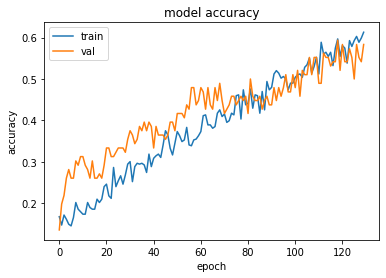

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

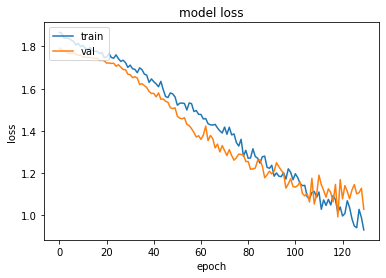

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
!mv /content/chkp /content/gdrive/MyDrive/TSN_DATASET/weights

mv: inter-device move failed: '/content/chkp' to '/content/gdrive/MyDrive/TSN_DATASET/weights/chkp'; unable to remove target: Directory not empty
